# Import libraries

In [278]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import fnmatch
import seaborn as sns
import datetime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set variables to find files

In [305]:
task = 'fmcfc'
cohorts = ['cohoMIN5', 'cohoMAP1', 'cohoMAP2'] #['cohoMIN2', 'cohoMIN3', 'cohoMAP1', 'cohoMAP2']
exp_folder = "/home/anacarol/Project/analyse/"
dir_dict = {}
for cohort in cohorts:
    for roots, dirs, files in os.walk(exp_folder+cohort):
        if roots.endswith('AB'):
            if task in roots:
                dir_dict[cohort] = roots #if roots.endswith('My_WebCam')
# cb_file = [f for f in os.listdir(exp_dict['directory']) if f.endswith('.csv')]
dir_dict

{'cohoMIN5': '/home/anacarol/Project/analyse/cohoMIN5/cohoMIN5_fmcfc_AB',
 'cohoMAP1': '/home/anacarol/Project/analyse/cohoMAP1/cohoMAP1_fmcfc_AB',
 'cohoMAP2': '/home/anacarol/Project/analyse/cohoMAP2/cohoMAP2_fmcfc_AB'}

Example on how to get info for specific cohort

In [306]:
cohort = 'cohoMIN3'
files = [f for f in os.listdir(dir_dict[cohort]) if f.endswith('.csv')]
video_info = pd.read_csv(os.path.join(dir_dict[cohort],files[0]))
summary = pd.read_csv(os.path.join(dir_dict[cohort],files[1]))

KeyError: 'cohoMIN3'

In [307]:
summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         50 non-null     int64  
 1   File               50 non-null     object 
 2   FileLength         50 non-null     float64
 3   MotionCutoff       50 non-null     float64
 4   FreezeThresh       50 non-null     float64
 5   MinFreezeDuration  50 non-null     float64
 6   bin                50 non-null     object 
 7   range(f)           50 non-null     object 
 8   Motion             50 non-null     float64
 9   Freezing           50 non-null     float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.0+ KB


- columns: 0 - nothing important can be dropped
- File - File path to videos - can be used to get session and time
- FileLength - Length of Motion and Freezing after light detection for start and end
- MotionCutoff - Cutoff to be considered motion
- FreezeThresh - threshold for freezing
- MinFreezeDuration - Minimum number of frames to be considered freezing (usually ~1s)
- bin - bins used
- range(f) - range of the length analysed
- Motion - average motion in range
- Freezing - average freezing in range

# Combine summaries and wrangle dataframe

- combine summaries from all defined cohorts
- get cohort, mouse ID, session from filepath
- combine info from summaries with mice info

## Get summary for all cohorts of interest

In [308]:
allcoho_summary = pd.DataFrame()
for cohort, dpath in dir_dict.items():
    video_info = pd.read_csv(os.path.join(dpath,'BehVideo_info.csv'))
    summary = pd.read_csv(os.path.join(dpath,'SummaryStats.csv'))
    freez_summary = summary[['File',
                            'FileLength',
                            'Freezing']]
    # From File name extract session date and time and mouse ID
    freez_summary['cohort'] = freez_summary.apply(lambda row: row['File'].split('/')[-6], axis=1)
    freez_summary['mouse_id'] = freez_summary.apply(lambda row: (row['File'].split('/')[-4]).split('_')[-1], axis=1)
    freez_summary['session_date'] = freez_summary.apply(lambda row: datetime.datetime.strptime((row['File'].split('/')[-3]), "%Y_%m_%d").date(), axis=1)
    freez_summary['session_time'] = freez_summary.apply(lambda row: datetime.datetime.strptime((row['File'].split('/')[-2]), "%H_%M_%S").time(), axis=1)
    allcoho_summary = pd.concat([allcoho_summary, freez_summary])

/tmp/ipykernel_6026/3916195026.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  freez_summary['cohort'] = freez_summary.apply(lambda row: row['File'].split('/')[-6], axis=1)
/tmp/ipykernel_6026/3916195026.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  freez_summary['mouse_id'] = freez_summary.apply(lambda row: (row['File'].split('/')[-4]).split('_')[-1], axis=1)
/tmp/ipykernel_6026/3916195026.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [309]:
# make sure all cohorts are with proper acronyms
allcoho_summary['cohort'] = allcoho_summary.apply(lambda row: row['cohort'][:8], axis=1) 

## Import mice info

In [310]:
mice_info_path = '/home/anacarol/'
mice_info = pd.read_csv(os.path.join(mice_info_path, "ExpMouseDatabase.csv"))

In [311]:
mice_cfc_coho = mice_info[(mice_info['Cohort'].isin(cohorts)) & (mice_info['Task'].str.contains(task))]
mice_cfc_coho.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 9 to 89
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Cohort                    19 non-null     object 
 1   Mouse ID                  19 non-null     object 
 2   Exp ID                    19 non-null     object 
 3   Sex                       19 non-null     object 
 4   Genotype                  19 non-null     object 
 5   Virus                     19 non-null     object 
 6   DOB                       19 non-null     object 
 7   Imaging quality - by eye  9 non-null      object 
 8   Task                      19 non-null     object 
 9   Exp Start                 19 non-null     object 
 10  fmcfcGroup                19 non-null     object 
 11  Hist needed               17 non-null     object 
 12  Hist Status               14 non-null     object 
 13  RawDataChecked            0 non-null      float64
 14  BehDataProce

In [312]:
mice_cfc_coho = mice_cfc_coho[['Cohort', 'Exp ID', 'Sex', 'Genotype', 'DOB', 'Exp Start', 'fmcfcGroup']]
mice_cfc_coho.columns = ['cohort', 'mouse_id', 'sex', 'genotype', 'dob', 'exp_start', 'exp_group']
mice_cfc_coho['dob'] = mice_cfc_coho.apply(lambda row: datetime.datetime.strptime(row['dob'], "%d/%m/%Y").date(), axis=1)
mice_cfc_coho['exp_start'] = mice_cfc_coho.apply(lambda row: datetime.datetime.strptime(row['exp_start'], "%d/%m/%Y").date(), axis=1)
mice_cfc_coho

cohort mouse_id sex          genotype         dob   exp_start exp_group
9   cohoMAP1      m4L   M           APP hom  2020-07-13  2021-10-04      ABAB
11  cohoMAP1      m70   M           APP hom  2020-07-13  2021-10-04      ABBA
13  cohoMAP1      m7L   M           APP hom  2020-07-13  2021-10-04      BABA
15  cohoMAP1      m7R   M           APP hom  2020-07-13  2021-10-04      BAAB
17  cohoMAP2      mAR   M           APP hom  2020-07-13  2021-09-18      BAAB
19  cohoMAP2      mEL   M  APP hom / PV het  2020-06-15  2021-09-18      BAAB
21  cohoMAP2      mE0   M  APP hom / PV het  2020-06-15  2021-09-18      BABA
23  cohoMAP2      mFL   M  APP hom / PV het  2020-08-01  2021-09-18      ABAB
25  cohoMAP2      mFR   M  APP hom / PV het  2020-08-01  2021-09-18      ABBA
71  cohoMIN5      mA0   M                WT  2021-07-05  2022-08-29      BABA
73  cohoMIN5      mA1   M                WT  2021-07-05  2022-08-29      ABBA
75  cohoMIN5     mA10   M                WT  2021-07-05  2022-08-29      ABAB
77  cohoMIN5      mB1   M                WT  2021-07-12  2022-08-29      ABAB
79  cohoMIN5     mB10   M                WT  2021-07-12  2022-08-29      BAAB
81  cohoMIN5      mD0   M                WT  2021-07-12  2022-08-29      ABBA
83  cohoMIN5      mE3   M                WT  2021-07-05  2022-08-29      ABBA
85  cohoMIN5     mE20   M                WT  2021-07-05  2022-08-29      BAAB
87  cohoMIN5      mC1   M                WT  2021-07-10  2022-08-29      BAAB
89  cohoMIN5     mC20   M                WT  2021-07-10  2022-08-29      BABA

## Merge result summary with mice info

In [313]:
cfc_results = pd.merge(allcoho_summary, mice_cfc_coho, how='left', on=['cohort', 'mouse_id'])
cfc_results

File  FileLength   Freezing  \
0   /home/anacarol/Project/raw/cohoMIN5/cohoMIN5_f...      5448.0   2.422907   
1   /home/anacarol/Project/raw/cohoMIN5/cohoMIN5_f...      5598.0  64.397999   
2   /home/anacarol/Project/raw/cohoMIN5/cohoMIN5_f...      5884.0   4.571720   
3   /home/anacarol/Project/raw/cohoMIN5/cohoMIN5_f...      5453.0  68.219329   
4   /home/anacarol/Project/raw/cohoMIN5/cohoMIN5_f...     12784.0  30.890175   
..                                                ...         ...        ...   
90  /home/anacarol/Project/raw/cohoMAP2/cohoMAP2_f...      5453.0  11.204841   
91  /home/anacarol/Project/raw/cohoMAP2/cohoMAP2_f...     12075.0  62.732919   
92  /home/anacarol/Project/raw/cohoMAP2/cohoMAP2_f...      5453.0  14.377407   
93  /home/anacarol/Project/raw/cohoMAP2/cohoMAP2_f...      5455.0  77.323556   
94  /home/anacarol/Project/raw/cohoMAP2/cohoMAP2_f...      5451.0  62.795817   

      cohort mouse_id session_date session_time sex genotype         dob  \
0   cohoMIN5     mC20   2022-08-29     10:04:23   M       WT  2021-07-10   
1   cohoMIN5     mC20   2022-09-02     10:08:41   M       WT  2021-07-10   
2   cohoMIN5     mC20   2022-08-30     10:29:02   M       WT  2021-07-10   
3   cohoMIN5     mC20   2022-09-01     10:09:08   M       WT  2021-07-10   
4   cohoMIN5     mC20   2022-08-31     10:31:57   M       WT  2021-07-10   
..       ...      ...          ...          ...  ..      ...         ...   
90  cohoMAP2      mAR   2021-10-18     09:28:34   M  APP hom  2020-07-13   
91  cohoMAP2      mAR   2021-10-20     09:30:05   M  APP hom  2020-07-13   
92  cohoMAP2      mAR   2021-10-19     09:33:01   M  APP hom  2020-07-13   
93  cohoMAP2      mAR   2021-10-21     09:25:36   M  APP hom  2020-07-13   
94  cohoMAP2      mAR   2021-10-22     09:25:37   M  APP hom  2020-07-13   

     exp_start exp_group  
0   2022-08-29      BABA  
1   2022-08-29      BABA  
2   2022-08-29      BABA  
3   2022-08-29      BABA  
4   2022-08-29      BABA  
..         ...       ...  
90  2021-09-18      BAAB  
91  2021-09-18      BAAB  
92  2021-09-18      BAAB  
93  2021-09-18      BAAB  
94  2021-09-18      BAAB  

[95 rows x 12 columns]

### Correct some of the columns data

In [314]:
# there is a mistake on cohoMAP2 exp_start, so here we just manually fix that
cfc_results.loc[cfc_results['cohort'] == 'cohoMAP2','exp_start'] = datetime.date(2021,10,18)

In [315]:
# calculate number of session based on start date and session date
cfc_results['session_n'] = (cfc_results['session_date']-cfc_results['exp_start']+datetime.timedelta(1)).dt.days

In [316]:
# add A for conditioning day on exp group
cfc_results['exp_group'] = cfc_results.apply(lambda row: row['exp_group'][:2]+'A'+row['exp_group'][-2:], axis=1)

In [317]:
# create column with specific context for that session
cfc_results['session_ctx'] = cfc_results.apply(lambda row: row['exp_group'][row['session_n']-1], axis=1)

In [318]:
# create column with hab info and another with rec info
cfc_results['hab'] = cfc_results.apply(lambda row: row['exp_group'][:2], axis=1)
cfc_results['rec'] = cfc_results.apply(lambda row: row['exp_group'][-2:], axis=1)

In [319]:
# define tag for plottings
def define_tag(row):
    if row['session_n'] <= 2:
        tag = 'Hab'+row['session_ctx']
    elif row['session_n'] == 3:
        tag = 'Cond'
    else:
        tag = 'Rec'+row['session_ctx']
    return tag
    
cfc_results['session_tag'] = cfc_results.apply(define_tag, axis=1)

In [320]:
def clear_genotype(row):
    if 'APP' in row['genotype']:
        gen = 'APP'
    elif 'WT' in row['genotype']:
        gen = 'WT'
    return gen
cfc_results['genotype'] = cfc_results.apply(clear_genotype, axis=1)

In [321]:
cfc_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95 entries, 0 to 94
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   File          95 non-null     object 
 1   FileLength    95 non-null     float64
 2   Freezing      95 non-null     float64
 3   cohort        95 non-null     object 
 4   mouse_id      95 non-null     object 
 5   session_date  95 non-null     object 
 6   session_time  95 non-null     object 
 7   sex           95 non-null     object 
 8   genotype      95 non-null     object 
 9   dob           95 non-null     object 
 10  exp_start     95 non-null     object 
 11  exp_group     95 non-null     object 
 12  session_n     95 non-null     int64  
 13  session_ctx   95 non-null     object 
 14  hab           95 non-null     object 
 15  rec           95 non-null     object 
 16  session_tag   95 non-null     object 
dtypes: float64(2), int64(1), object(14)
memory usage: 13.4+ KB


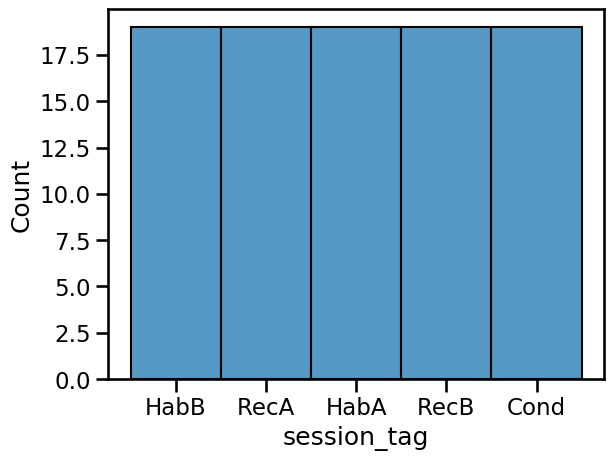

In [322]:
sns.set_context("talk")
ax = sns.histplot(data=cfc_results, x='session_tag')

plot results

In [323]:
mice_info = cfc_results[['cohort','mouse_id', 'sex', 'genotype', 'dob', 'exp_group']]
mice_info = mice_info.drop_duplicates()

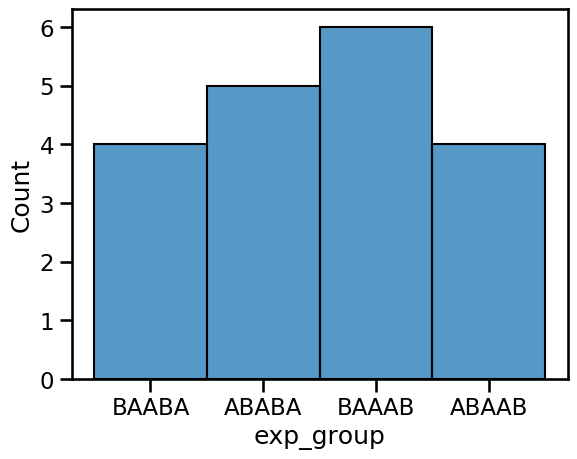

In [324]:
sns.set_context("talk")
ax = sns.histplot(data=mice_info, x='exp_group')

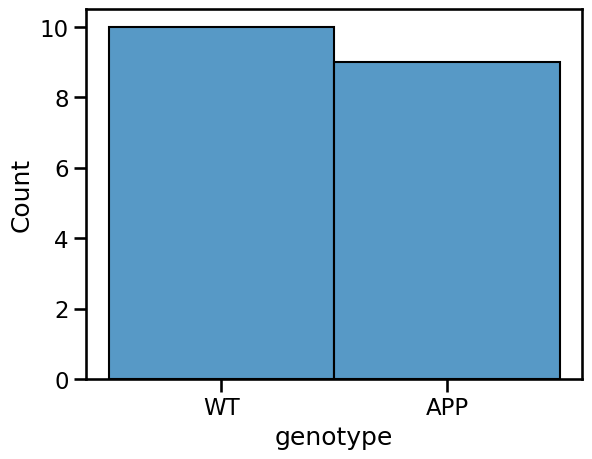

In [325]:
sns.set_context("talk")
ax = sns.histplot(data=mice_info, x='genotype')

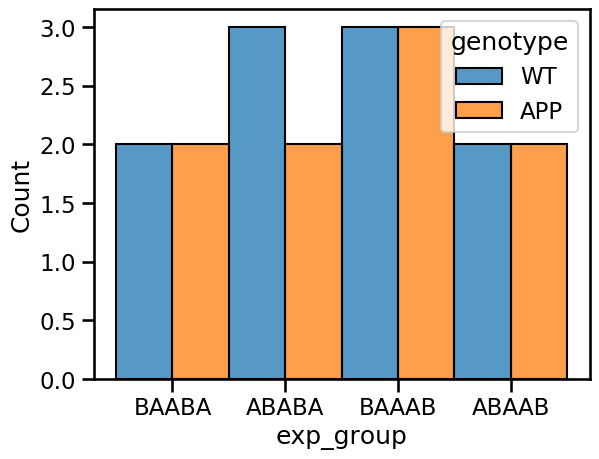

In [326]:
sns.set_context("talk")
ax = sns.histplot(data=mice_info, x='exp_group', hue='genotype', multiple='dodge')

/miniconda/envs/eztrack/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


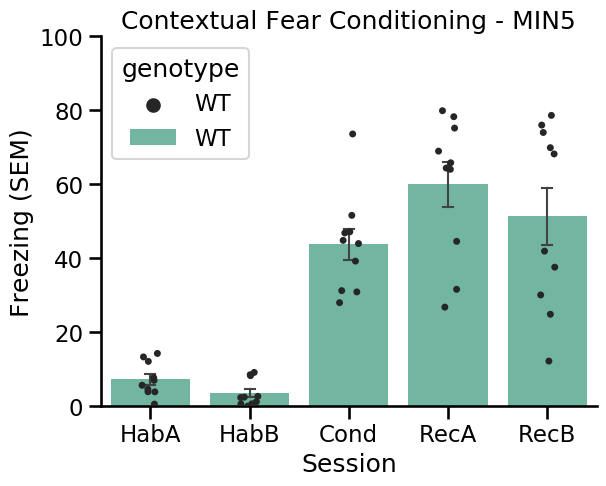

In [329]:
sns.set_context("talk")
data = cfc_results[cfc_results['cohort'] == 'cohoMIN5']
ax = sns.barplot(y='Freezing', x='session_tag', hue='genotype' ,data=data, order=['HabA', 'HabB', 'Cond', 'RecA', 'RecB'], errorbar=('se'), capsize=.1, errwidth=1.5, palette = sns.color_palette("Set2"))
ax = sns.stripplot(y='Freezing', x='session_tag', hue='genotype' ,data=data, dodge = True, color='.3', order=['HabA', 'HabB', 'Cond', 'RecA', 'RecB'])
ax.set_title('Contextual Fear Conditioning - MIN5')
ax.set_ylabel('Freezing (SEM)')
ax.set_xlabel('Session')
ax.set(ylim=(0, 100))
sns.despine()

/miniconda/envs/eztrack/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


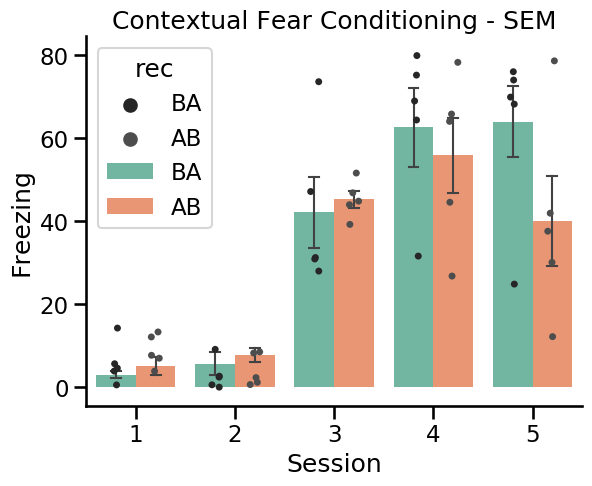

In [304]:
sns.set_context("talk")
data = cfc_results #[cfc_results['cohort'] == 'cohoMIN2']
ax = sns.barplot(y='Freezing', x='session_n', hue='rec' ,data=data, errorbar=('se'), capsize=.1, errwidth=1.5, palette = sns.color_palette("Set2"))
ax = sns.stripplot(y='Freezing', x='session_tag', hue='rec' ,data=data, dodge = True, color='.3', order=['HabA', 'HabB', 'Cond', 'RecA', 'RecB'])
ax.set_title('Contextual Fear Conditioning - SEM')
ax.set_xlabel('Session')
sns.despine()